In [710]:
# %reset-f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [711]:
from res_ind_lib import *

from sorted_nicely import *
from replace_with_warning import *

import os, time
import warnings
warnings.filterwarnings("always",category=UserWarning)

In [712]:
import numpy as np
import pandas as pd

#Pandas display options
# pd.set_option('display.max_colwidth', 200)
# pd.set_option('display.width', 200)
# pd.set_option('display.precision', 10)
# pd.set_option('display.max_rows', 500)

import matplotlib.pylab as plt
%matplotlib inline
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 15}
plt.rc('font', **font)

from fancy_plots import *

# Options and parameters

In [713]:
protection_from_flopros = True #else assumes number per WB income group
no_protection=True #overiides previous option. protection=1 everywhere


less_ratios = False #reduce the number of rp (for clarity when debugging)

use_GLOFRIS_flood = False  #else uses GAR (True does not work i think)

use_guessed_social= True #else keeps nans

use_avg_pe = True #otherwise 0 when no data


use_newest_wdi_findex_aspire = True  #too late to include new data just before report release

drop_unused_data=True #if true removes from df and cat_info the intermediate variables

In [714]:
economy = "country" #province, deparmtent

# Country dictionaries

In [715]:
#Names to WB names
any_to_wb = pd.read_csv("inputs/any_name_to_wb_name.csv",index_col="any",squeeze=True)

#GAR names with SIDS spec
gar_name_sids = pd.read_csv("inputs/gar_name_sids.csv")

#iso3 to wb country name table
iso3_to_wb=pd.read_csv("inputs/iso3_to_wb_name.csv").set_index("iso3").squeeze()

#iso2 to iso3 table
iso2_iso3 = pd.read_csv("inputs/names_to_iso.csv", usecols=["iso2","iso3"]).drop_duplicates().set_index("iso2").squeeze() #the tables has more lines than countries to account for several ways of writing country names

In [716]:
gar_name_sids['wbcountry'] = gar_name_sids.reset_index().country.replace(any_to_wb)

list_of_sids = gar_name_sids[gar_name_sids.isaSID=="SIDS"].dropna().reset_index().wbcountry

In [717]:
list_of_sids;

# Macro Data

##  Economic data from the world bank

In [718]:
the_file = "inputs/wb_data.csv" if use_newest_wdi_findex_aspire else "inputs/wb_data_backup.csv"

nb_weeks = (time.time()-os.stat(the_file).st_mtime )/(3600*24*7)
if nb_weeks>20: 
    warnings.warn("World bank data are "+str(int(nb_weeks))+" weeks old. You may want to download them again.")
df=pd.read_csv(the_file).set_index(economy)


if not use_newest_wdi_findex_aspire:
    df["urbanization_rate"]=pd.read_csv("inputs/wb_data.csv").set_index(economy)["urbanization_rate"]
    ## Drops here the data not used, to avoid it counting as missing data
    df = df.drop(["plgp","unemp","bashs","ophe", "axhealth"],axis=1)



df.dropna().shape

(82, 8)

## Definitions

In [719]:
# share of poor individuals, we chose the bottom 20
df["pov_head"]=0.2 
ph=df["pov_head"]

df.head()

,gdp_pc_pp,pop,share1,urbanization_rate,axfin_p,axfin_r,social_p,social_r,pov_head
country,,,,,,,,,
Afghanistan,1808.126028,32526562.0,NaN,0.26703,0.022336,0.044609,0.111074,0.043163,0.2
Albania,11015.163884,2889167.0,0.0885,0.57407,0.044618,0.096454,0.243888,0.168006,0.2
Algeria,13795.243289,39666519.0,NaN,0.70727,0.101800,0.164780,NaN,NaN,0.2
American Samoa,NaN,55538.0,NaN,0.87202,NaN,NaN,NaN,NaN,0.2
Andorra,NaN,70473.0,NaN,0.85115,NaN,NaN,NaN,NaN,0.2


## EUsilc and other countries

In [720]:
silc = pd.read_csv("inputs/social_ratios.csv") #XXX: there is data from ASPIRE in social_ratios. Use fillna instead to update df.
#indexes with wold bank names
silc = silc.set_index(silc.cc.replace({"EL":"GR","UK":"GB"}).replace(iso2_iso3).replace(iso3_to_wb)) #UK and greece have differnt codes in Europe than ISO2. 
silc.head()



,cc,social_p,social_r,eusilc,aspire
cc,,,,,
Austria,AT,0.517166,0.408164,1,0
Belgium,BE,0.651173,0.402523,1,0
Bulgaria,BG,0.663095,0.404463,1,0
Switzerland,CH,0.479703,0.305042,1,0
Cyprus,CY,0.479651,0.333553,1,0


In [721]:
#Monitoring differences between SILC and ASPIRE
(df[["social_p","social_r"]] - silc[["social_p","social_r"]] ).dropna()


#updates socials with SILC when no data from WB
df.ix[silc.index,["social_p","social_r"]]  = silc[["social_p","social_r"]] 


df.dropna().shape

df.ix["Togo","social_r"]=np.nan

## Guessed transfers

In [722]:
guessed_social = pd.read_csv("inputs/df_social_transfers_statistics.csv", index_col=0)[["social_p_est","social_r_est"]]
guessed_social.columns = ["social_p", "social_r"]
guessed_social.head()


guessed_social.ix["Togo"]

social_p    0.092560
social_r    0.094162
Name: Togo, dtype: float64

In [723]:
if use_guessed_social:
    df = df.fillna(guessed_social.clip(lower=0, upper=1))
    

df.dropna().shape    

(129, 9)

## plot social

0.29250457146177283
0.1742343041893773
0.2029918791598343
0.13714931946774125
0.10779453139897054


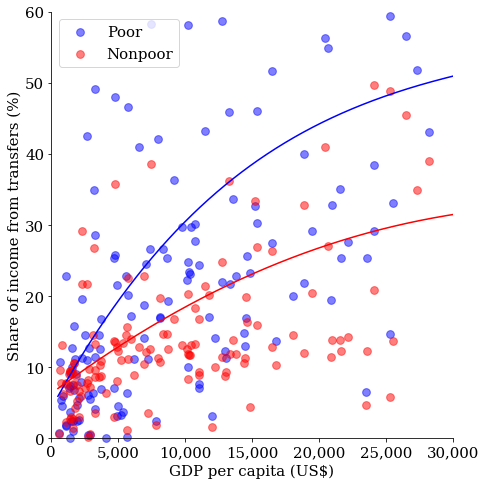

In [724]:
plt.figure(figsize=(7,7))
from scipy import interpolate


print(df.social_p.mean())
print(df.social_r.mean())

df2=df.query("gdp_pc_pp<30000 & social_p<.6 ")
print(df2.social_p.mean())
print(df2.social_r.mean())

plt.scatter(df2.gdp_pc_pp,100*df2.social_p, c="blue", s=60, alpha=.5 , clip_on=False)
plt.scatter(df2.gdp_pc_pp,100*df2.social_r, c="red", s =60,  alpha=.5, clip_on=False)

plt.legend(["Poor","Nonpoor"], loc=2, prop=font, )

x=df.dropna()["gdp_pc_pp"].values
yp=df.dropna()["social_p"].values
yr=df.dropna()["social_r"].values


#x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
#y = np.sin(x)
f_p = interpolate.UnivariateSpline(x,yp,k=4)
f_r = interpolate.UnivariateSpline(x,yr,k=4)
#tck = interpolate.splrep(x,y, s=0)


x=np.linspace(500.0, 30000, num=1000)
plt.plot(x,100*f_p(x), c="blue")
plt.plot(x,100*f_r(x), c="red")
print(f_p(2000))

plt.xlim(xmin=0,xmax=30000)
plt.ylim(0,ymax=60)


plt.ylabel("Share of income from transfers (%)")
plt.xlabel("GDP per capita (US$)")

x_thousands_sep()
spine_and_ticks(plt.gca())

plt.savefig('img/Diversification.png')


## HFA

In [725]:

#2015 hfa
hfa15 =  pd.read_csv("inputs/HFA_all_2013_2015.csv")
hfa15 =  hfa15.set_index(replace_with_warning(hfa15["Country name"],any_to_wb))

# READ THE LAST HFA DATA
hfa_newest = pd.read_csv("inputs/HFA_all_2011_2013.csv")
hfa_newest = hfa_newest.set_index(replace_with_warning(hfa_newest["Country name"],any_to_wb))

# READ THE PREVIOUS HFA DATA
hfa_previous = pd.read_csv("inputs/HFA_all_2009_2011.csv")
hfa_previous = hfa_previous.set_index(replace_with_warning(hfa_previous["Country name"],any_to_wb))

#most recent values... if no 2011-2013 reporting, we use 2009-2011
hfa_oldnew=pd.concat([hfa_newest, hfa_previous, hfa15], axis=1,keys=['new', 'old', "15"]) #this is important to  join the list of all countries
hfa = hfa_oldnew["new"].fillna(hfa_oldnew["old"]);
hfa = hfa_oldnew["15"].fillna(hfa_oldnew["new"].fillna(hfa_oldnew["old"]));

# access to early warning = priority for action 2, indicator 3 of the HFA
hfa["shew"]=1/5*hfa["P2-C3"] # between zero and 1. 

# ability to scale up = average of priority for action 5 of the HFA
hfa["prepare_scaleup"]=(hfa["P4-C2"]+hfa["P5-C2"]+hfa["P4-C5"])/3/5 # between zero and 1
hfa["finance_pre"] = (1+hfa["P5-C3"])/6 #betwenn 0 and 1


df[["shew","prepare_scaleup","finance_pre"]]=hfa[["shew","prepare_scaleup","finance_pre"]]

#assumes no reporting is bad situation (caution! do the fillna after inputing to df to get the largest set of index)
df[["shew","prepare_scaleup","finance_pre"]]=df[["shew","prepare_scaleup","finance_pre"]].fillna(0)

df.ix["Finland"];
#df.head()
df.dropna().shape 

(129, 12)

## plot HAF

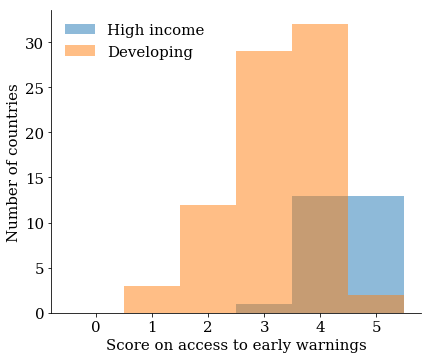

In [726]:

df_ = df.copy()
df_["income_group"]=pd.read_csv("inputs/income_groups.csv",header =4,index_col=2)["Income group"].dropna()
df_ = df_.replace(0,np.nan).dropna()

hi = [c for c in df_.index if "High income" in df_.ix[c,"income_group"]]
dev= [c for c in df_.index if "High income" not in df_.ix[c,"income_group"]]
df_.income_group;

fig = plt.figure(figsize=(6,5))

plt.hist(df_.ix[hi ,"shew"]*5,bins=[-.5,.5,1.5,2.5,3.5,4.5,5.5], align="mid", alpha=0.5)
plt.hist(df_.ix[dev,"shew"]*5,bins=[-.5,.5,1.5,2.5,3.5,4.5,5.5], align="mid", alpha=0.5)

ax=plt.gca()

spine_and_ticks(ax)

plt.xlabel("Score on access to early warnings")
plt.ylabel("Number of countries")

ax.set_xticks([0,1,2,3,4,5]);

plt.legend(["High income", "Developing"], prop=font, loc="best", frameon=False);

plt.savefig("img/EarlyWarning_socres.png")
plt.savefig("img/EarlyWarning_socres.pdf")




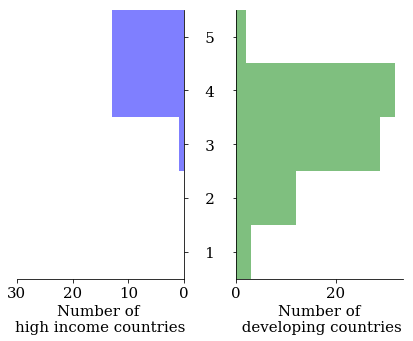

In [727]:

x1 = df_.ix[hi ,"shew"].value_counts()
x2 = df_.ix[dev,"shew"].value_counts()
y = list(set(x1.index.tolist()+ x2.index.tolist()))
y.sort()

x1 = x1.reindex(y).fillna(0).sort_index()
x2 = x2.reindex(y).fillna(0).sort_index()


fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True, figsize=(6,5))
ax1.barh(y, x1, align='center', height=.2, color="blue", alpha=0.5)
ax2.barh(y, x2, align='center', height=.2, color="green", alpha=0.5)



ax1.set_xlim(0,30)
ax2.set_ylim(0.1,1.1)

ax1.invert_xaxis()
#removes ticks 
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')


ax2.set_xlabel("Number of\n developing countries")
ax1.set_xlabel("Number of \nhigh income countries")


# ax2.set_ylabel("Score on access to early warnings")


ax1.set_yticks([0.2,.4,.6,.8,1])
ax1.set_yticklabels(["   1","   2","   3","   4","   5"]);

spine_and_ticks(ax2)
spine_and_ticks(ax1,reverted=True)


plt.savefig("img/EarlyWarning_socres_pyramid.png")
plt.savefig("img/EarlyWarning_socres_pyramid.pdf")

## Country Ratings

In [728]:
#Reads the data and check its not too old
the_credit_rating_file ="inputs/cred_rat.csv"
nb_weeks = (time.time()-os.stat(the_credit_rating_file).st_mtime )/(3600*24*7)
if nb_weeks>3: 
    warnings.warn("Credit ratings are "+str(int(nb_weeks))+" weeks old. Get new ones at http://www.tradingeconomics.com/country-list/rating")
ratings_raw  =pd.read_csv(the_credit_rating_file,dtype="str").dropna(how="all")
ratings_raw=ratings_raw.rename(columns={"Unnamed: 0": "country_in_ratings"})[["country_in_ratings","S&P","Moody's","Fitch"]]

#The creidt rating sources calls DR Congo just Congo
ratings_raw.country_in_ratings= ratings_raw.country_in_ratings.str.strip().replace(["Congo"],["Congo, Dem. Rep."])

ratings_raw["country"]= replace_with_warning(ratings_raw.country_in_ratings.apply(str.strip),any_to_wb)

ratings_raw=ratings_raw.set_index("country")

def mystriper(string):
    """strip blanks and converts everythng to lower case"""
    if type(string)==str:
        return str.strip(string).lower()
    else:
        return string
        
#to lower case and strips blanks
ratings_raw=ratings_raw.applymap(mystriper)    

#Transforms ratings letters into 1-100 numbers
rat_disc = pd.read_csv("inputs/cred_rat_dict.csv")
ratings=ratings_raw
ratings["S&P"].replace(rat_disc["s&p"].values,rat_disc["s&p_score"].values,inplace=True)
ratings["Moody's"].replace(rat_disc["moodys"].values,rat_disc["moodys_score"].values,inplace=True)
ratings["Fitch"].replace(rat_disc["fitch"].values,rat_disc["fitch_score"].values,inplace=True)
ratings["rating"]=ratings.mean(axis=1)/100

df["rating"] = ratings["rating"]
df["rating"].fillna(0,inplace=True)  #assumes no rating is bad rating

df.dropna().shape 

C:\Users\WB451855\OneDrive - WBG\resilience_indicator_SIDS\replace_with_warning.py:21: UserWarning: These entries were not found in the dictionary:
European Union
  warnings.warn("These entries were not found in the dictionary:\n"+joiner.join(series_in[are_missing].unique()))


(129, 13)

## ratings + HFA

In [729]:
# Ability and willingness to improve transfers after the disaster
df["borrow_abi"]=(df["rating"]+df["finance_pre"])/2 

## Capital data

In [730]:
#data arranged from Penn tables
k_data=pd.read_csv("inputs/capital_data.csv", usecols=["code","cgdpo","ck"]).replace({"ROM":"ROU","ZAR":"COD"}).rename(columns={"cgdpo":"prod_from_k","ck":"k"})#Zair is congo

#matches names in the dataset with world bank country names
iso_country = pd.read_csv("inputs/iso3_to_wb_name.csv", index_col="iso3")
k_data.set_index("code",inplace=True)
k_data["country"]=iso_country["country"]
cond = k_data["country"].isnull()
if cond.sum()>0:
     warnings.warn("this countries appear to be missing from iso3_to_wb_name.csv: "+" , ".join(k_data.index[cond].values))
k_data=k_data.reset_index().set_index("country")

# average productivity of capital
df["avg_prod_k"]=k_data["prod_from_k"]/k_data["k"]

#capital held per person on average
# df["k"] = df["gdp_pc_pp"]/df["avg_prod_k"]

#df.head()
df.dropna().shape 

(126, 15)

## Report missing data for the national studies

In [731]:
from report_tables import report_missing_data

report = report_missing_data(df)
report.to_csv("results/missing_data_report.csv")

report.head(n=15)

,nb_missing,missing_data
country,,
Lebanon,1,share1
"Hong Kong SAR, China",1,share1
Iraq,1,share1
Jordan,1,share1
"Korea, Rep.",1,share1
Kuwait,1,share1
Malta,1,share1
New Zealand,1,share1
Nicaragua,1,avg_prod_k


In [732]:
print("It seems that we have macro data for {} countries including {} SIDS".format(len(df)-len(report),len(df.loc[list(list_of_sids),:])-len(report.loc[list(list_of_sids),:].dropna())))

It seems that we have macro data for 126 countries including 7 SIDS


In [733]:
[sids for sids in list_of_sids if sids not in list(report.loc[list(list_of_sids),:].dropna().reset_index().country)]

['Anguilla',
 'Virgin Islands, British',
 'Cape Verde',
 'Comoros',
 'Dominican Republic',
 'Jamaica',
 'Mauritius']

In [734]:
mdsids = report.loc[list(list_of_sids),:].dropna()

In [735]:
for missingdata in df.columns:
    mdsids[missingdata] = [missingdata in [y.strip(' ') for y in x.split(",")] for x in mdsids.missing_data]

In [736]:
mdsids = mdsids.loc[:,(mdsids != 0).any(axis=0)]

In [737]:
mdsids.to_csv("results/missing_data_RI_SIDS.csv")

## manual parametrization

In [738]:

#Reconstruction time
df["T_rebuild_K"] = 3

# how much early warning reduces vulnerability
df["pi"] = 0.2

#income elasticity
df["income_elast"] = 1.5

#discount rate
df["rho"] = 6/100


df["shareable"]=0.8  #target of asset losses to be covered by scale up
df["max_increased_spending"] = 0.05 # 5% of GDP in post-disaster support maximum, if everything is ready      


In [739]:
df.dropna().shape 

(126, 21)

In [740]:
macro_data_sids = df.loc[list(list_of_sids),:].dropna().reset_index().country.unique()

In [741]:
#SIDS with macro data
macro_data_sids

array(['Comoros', 'Dominican Republic', 'Jamaica', 'Mauritius'], dtype=object)

# Hazard data

## Exposure from Glofris

In [742]:
#Esposure data, by return peridd 
expo = pd.read_csv("inputs/exposure_econ_return_period.csv",index_col="country");

df["fa_glofris"]=fa=expo["100"].replace(0, np.nan)

##RETURN PERIOD INFORMATION

fa_ratios = expo.div(fa,axis=0).dropna()

fa_ratios.columns=fa_ratios.columns.map(float)
fa_ratios.columns

fa_ratios=fa_ratios.sort_index(axis=1)
fa_ratios.to_csv("inputs/fa_ratios.csv")

fa_ratios.columns.name = "rp"

fa_ratios.head()

##MULTIHAZARD FA RATIOS
fa_ratios =pd.concat((fa_ratios, fa_ratios/fa_ratios),
     keys=["river","bigriver"], names=["hazard",]).reset_index("hazard").set_index("hazard", append=True).sort_index()

if less_ratios:
    fa_ratios = fa_ratios[[5,10]]

fa_ratios = fa_ratios.stack()

fa_ratios.head()


if use_GLOFRIS_flood:
    df.fa  = df.fa_glofris

In [743]:
#SIDS with Glofris data
df.loc[list(list_of_sids),:].dropna().reset_index().country.unique()

array(['Dominican Republic', 'Jamaica'], dtype=object)

### exposure bias 

In [744]:

def wavg(data,weights):
    #nan aware weighted average
    df_matched =pd.DataFrame({"data":data,"weights":weights}).dropna()
    return (df_matched.data*df_matched.weights).sum()/df_matched.weights.sum()

#Exposure bias from WB povmaps study
data = pd.read_excel("inputs/PEB_flood_povmaps.xlsx")[["iso","peb"]].dropna()
df["pe"] = data.set_index(data.iso.replace(iso3_to_wb)).peb-1


#Exposure bias from older WB DELTARES study
PEB_wb_deltares_older = pd.read_csv("inputs/PEB_wb_deltares.csv",skiprows=[0,1,2],usecols=["Country","Nation-wide"])
PEB_wb_deltares_older["country"] = replace_with_warning(PEB_wb_deltares_older["Country"],any_to_wb)

df["peb1"]=df["pe"]
df["peb2"]=PEB_wb_deltares_older.set_index("country").drop(["Country"],axis=1)

#Completes with bias from previous study when pov maps not available
df["pe"]=df["pe"].fillna(PEB_wb_deltares_older.set_index("country").drop(["Country"],axis=1).squeeze())

if use_avg_pe:
    df["pe"]=df["pe"].fillna(wavg(df["pe"],df["pop"]))
else:
    df["pe"].fillna(0)
    
#pops pe out of df
pe = df.pop("pe")

pe.ix["Finland"];
pe.head()

pe.sort_values(ascending=False)

# (100*pe).hist(bins=50)
pe.sort_values()

country
Zimbabwe             -1.000000
Rwanda               -0.712465
Mali                 -0.390000
Niger                -0.390000
Ethiopia             -0.330000
Burkina Faso         -0.300000
Sudan                -0.250094
Cambodia             -0.250000
Senegal              -0.250000
Moldova              -0.198387
Slovak Republic      -0.194074
Madagascar           -0.160000
Latvia               -0.159573
Bulgaria             -0.156645
Peru                 -0.147132
Lao PDR              -0.131407
Sri Lanka            -0.125768
Mexico               -0.119635
Lesotho              -0.110000
Tanzania             -0.100000
Bhutan               -0.095130
Albania              -0.070835
Vietnam              -0.068339
Poland               -0.052037
Fiji                 -0.051986
Afghanistan          -0.047908
Dominican Republic   -0.033771
Nigeria              -0.031768
Indonesia            -0.026308
Cote d'Ivoire        -0.020000
                        ...   
Jordan                0.184274


In [745]:
df.columns

Index(['gdp_pc_pp', 'pop', 'share1', 'urbanization_rate', 'axfin_p', 'axfin_r',
       'social_p', 'social_r', 'pov_head', 'shew', 'prepare_scaleup',
       'finance_pre', 'rating', 'borrow_abi', 'avg_prod_k', 'T_rebuild_K',
       'pi', 'income_elast', 'rho', 'shareable', 'max_increased_spending',
       'fa_glofris', 'peb1', 'peb2'],
      dtype='object')

In [746]:
df.drop(['peb1', 'peb2'],axis=1).dropna().shape 

(123, 22)

In [747]:
#SIDS with Glofris data and pe data
df.loc[list(list_of_sids),:].drop(['peb1', 'peb2'],axis=1).dropna().reset_index().country.unique()

array(['Dominican Republic', 'Jamaica'], dtype=object)

In [748]:
df[["peb1","peb2"]].dropna().corr()

,peb1,peb2
peb1,1.000000,0.419643
peb2,0.419643,1.000000


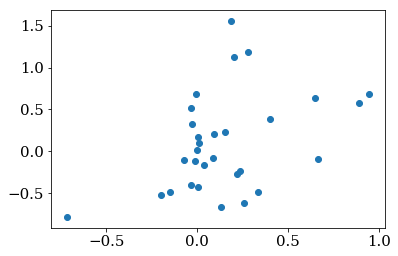

In [749]:
todraw = df[["peb1","peb2"]].dropna()
plt.scatter(todraw.peb1,todraw.peb2)

In [750]:
((todraw.peb1*todraw.peb2>0)).sum()/((todraw.peb1*todraw.peb2>0)).count()


0.56666666666666665

## Old PAGER method

In [751]:
pager=pd.read_csv("inputs/pager_vulnerabilities.csv",
                  usecols=["ISO-3digit","R_1","R_2","R_3","VV_1","VV_2","VV_3"],
                  )
pager= pager.set_index(replace_with_warning(pager["ISO-3digit"], iso3_to_wb))

#keeps only the lines for which we have a WB country
pager = pager[pager.index.isin(iso3_to_wb)]

#sorts vulnerabilites according to income
share =pager[["R_1","R_2","R_3"]]
damrat=pager[["VV_1","VV_2","VV_3"]]

damrat.columns=["R_1","R_2","R_3"]
p=(share.cumsum(axis=1).T.add(-df["pov_head"]).T).clip(lower=0)
poor=(share-p).clip(lower=0)

vp_old=(poor*damrat).sum(axis=1)/poor.sum(axis=1)
rich=share-poor

# df["vr"]
vr_old=(rich*damrat).sum(axis=1)/rich.sum(axis=1)

vp_old.ix["Lao PDR"]


C:\Users\WB451855\OneDrive - WBG\resilience_indicator_SIDS\replace_with_warning.py:21: UserWarning: These entries were not found in the dictionary:
ALA, ATA, BES, BVT, IOT, CXR, CCK, FLK, GUF, ATF, GIB, GLP, GGY, HMD, VAT, JEY, MTQ, MYT, MSR, NFK, PCN, REU, BLM, SHN, SPM, SGS, SJM, TKL, UMI, WLF, ESH
  warnings.warn("These entries were not found in the dictionary:\n"+joiner.join(series_in[are_missing].unique()))


0.25500000000000006

## Vulnerability from USGS PAGER

### Pager data

In [752]:
pager_description_to_aggregate_category = pd.read_csv("inputs/pager_description_to_aggregate_category.csv", index_col="pager_description", squeeze=True)
pager_description_to_aggregate_category.head()

pager_description
Adobe blocks (unbaked sundried mud block) walls                              fragile
Adobe block, mud mortar, wood roof and floors                                fragile
Adobe block, mud mortar, bamboo, straw, and thatch roof                      fragile
Adobe block, straw, and thatch roof cement-sand mortar                       fragile
Adobe block, mud mortar, reinforced concrete bond beam, cane and mud roof    fragile
Name: aggregate_category, dtype: object

In [753]:
PAGER_XL = pd.ExcelFile("inputs/PAGER_Inventory_database_v2.0.xls")
PAGER_XL.sheet_names

['Release_Notes', 'Rural_Non_Res', 'Urban_Non_Res', 'Rural_Res', 'Urban_Res']

In [754]:
pager_desc_to_code = pd.read_excel(PAGER_XL,sheetname="Release_Notes", parse_cols="B:C", skiprows=56).dropna().squeeze()
pager_desc_to_code.head()

#removes spaces and dots from PAGER description
pager_desc_to_code.Description = pager_desc_to_code.Description.str.strip(". ")

#replace double spaces with single spaces
pager_desc_to_code.Description = pager_desc_to_code.Description.str.replace("  "," ")

pager_desc_to_code = pager_desc_to_code.set_index("PAGER-STR")
pager_desc_to_code.head()

,Description
PAGER-STR,
W,Wood
W1,Wood stud-wall frame with plywood/gypsum board...
W2,"Wood frame, heavy members (with area > 5000 sq..."
W3,Wood light unbraced post and beam frame
W4,Wood panel or log construction


In [755]:
pager_code_to_aggcat = replace_with_warning( pager_desc_to_code.Description, pager_description_to_aggregate_category, joiner="\n")
pager_code_to_aggcat.head()

PAGER-STR
W      median
W1     median
W2     median
W3    fragile
W4    fragile
Name: Description, dtype: object

#### total share of each category of building per country

In [756]:

#gets share per agg category from the data in one of the sheets in PAGER_XL
def get_share_from_sheet(sheetname='Rural_Non_Res'):
    data = pd.read_excel(PAGER_XL,sheetname=sheetname).set_index("ISO-3digit") #data as provided in PAGER
    #rename column to aggregate category
    data_agg =    data[pager_code_to_aggcat.index].rename(columns = pager_code_to_aggcat)
    data_agg.head()
    #group by category and sum
    data_agg= data_agg.sum(level=0,axis=1)

    #PAGER ISO3 to WB name
    
    # return data_agg.set_index(replace_with_warning(data_agg.reset_index()["ISO-3digit"],iso3_to_wb, joiner="','")); 
    # print("data ignored from USPAGER for this places: "+", ".join(data.ix[['ALA','ATA','BES','BVT','IOT','CXR','CCK','FLK','GUF','ATF','GIB','GLP','GGY','HMD','VAT','JEY','MTQ','MYT','MSR','NFK','PCN','REU','BLM','SHN','SPM','SGS','SJM','TKL','UMI','WLF','ESH','XFF'], "Country Name"]))

    data_agg = data_agg.set_index(data_agg.reset_index()["ISO-3digit"].replace(iso3_to_wb));
    
    data_agg.index.name="country"
    return data_agg[data_agg.index.isin(iso3_to_wb)] #keeps only countries
    

rural_share= .5* get_share_from_sheet(sheetname='Rural_Non_Res')+.5*get_share_from_sheet(sheetname='Rural_Res')
urban_sare = .5* get_share_from_sheet(sheetname='Urban_Non_Res')+.5*get_share_from_sheet(sheetname='Urban_Res')


share = (rural_share.stack()*(1-df.urbanization_rate) + urban_sare.stack()*df.urbanization_rate).unstack().dropna()

share=  share[share.index.isin(iso3_to_wb)] 

share.sample(n=5)


,fragile,median,robust
country,,,
Eritrea,0.800000,0.200000,0.00000
Norway,0.067107,0.236803,0.69609
Denmark,0.000000,0.800000,0.20000
French Polynesia,0.532000,0.382000,0.08600
South Sudan,0.800000,0.200000,0.00000


#### sorts people in buildings according to income

In [757]:
agg_cat_to_v = pd.read_csv("inputs/aggregate_category_to_vulnerability.csv", sep=";", index_col="aggregate_category", squeeze=True)
agg_cat_to_v.head()

aggregate_category
fragile    0.7
median     0.3
robust     0.1
Name: vulnerability, dtype: float64

In [758]:
#sorts roof types according to income
p=(share.cumsum(axis=1).add(-df["pov_head"],axis=0)).clip(lower=0)
poor=(share-p).clip(lower=0)
poor.head()

rich=share-poor
rich.head()

#averages vulnerability accross roof type
vp_unshaved=((poor*agg_cat_to_v).sum(axis=1, skipna=False)/df["pov_head"] )
vr_unshaved=(rich*agg_cat_to_v).sum(axis=1, skipna=False)/(1-df["pov_head"])

## Comparing methods

(0, 0.72726880294999108)

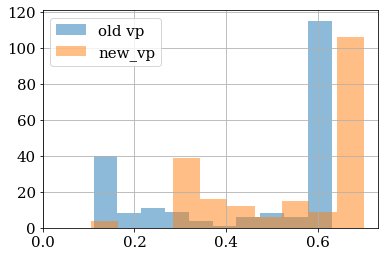

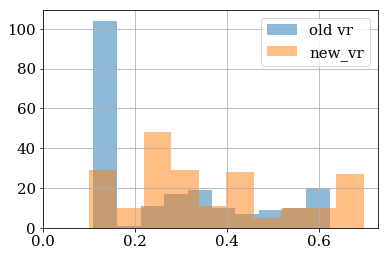

In [759]:
vp_old.hist(alpha=.5)
vp_unshaved.hist(alpha=.5)
plt.legend(["old vp", "new_vp"])
plt.savefig("img/old_new_vp")
plt.xlim(0)

plt.figure()
vr_old.hist(alpha=.5)
vr_unshaved.hist(alpha=.5)
plt.legend(["old vr", "new_vr"])
plt.savefig("img/old_new_vp")
plt.xlim(0)

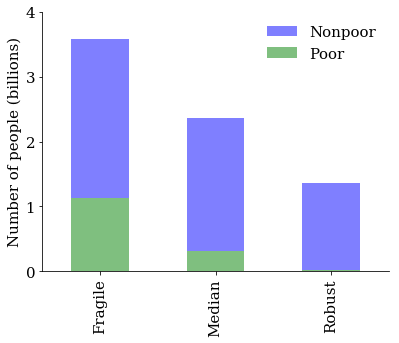

In [760]:
plt.figure(figsize=(6,5))
p = (poor.T*df["pop"]).T.sum()/1e9
p= p.rename(index=lambda s:s.capitalize())

r=(rich.T*df["pop"]).T.sum()/1e9
r=r.rename(index={"R_1":"Fragile", "R_2":"Median", "R_3":"Robust"})


r.plot.bar(color="blue", alpha=0.5, bottom=p  )
ax=p.plot.bar(color="green", alpha=0.5)

plt.legend(["Nonpoor","Poor"], prop=font, frameon=False)

plt.ylabel("Number of people (billions)")

spine_and_ticks(ax, thousands=False)
ax.set_yticks([0,1,2,3,4]);


plt.savefig("img/building_robustness")


In [761]:
x=(rich.T*df["pop"]).T.sum()
rs=(x.fragile/x.sum())


x=(poor.T*df["pop"]).T.sum()
ps=x.fragile/x.sum()

print('Over the {n} countries for which we have data, poor people are {x:.1f} times more likely than nonpoor people to use the fragile category of assets'.format(
        x=ps/rs, n=(rich.T*df["pop"]).T.dropna().shape[0]))

Over the 207 countries for which we have data, poor people are 1.8 times more likely than nonpoor people to use the fragile category of assets


## Exposure from GAR data and v


#Fraction of value destroyed
frac_value_destroyed_gar = pd.read_csv("intermediate/frac_value_destroyed_gar_completed.csv", index_col=["country", "hazard", "rp"]
                                       , squeeze=True);#Generated by pre_process\ GAR.ipynb

frac_value_destroyed_gar.dropna().unstack("country").shape

frac_value_destroyed_gar.to_csv("intermediate/frac_value_destroyed_gar.csv", encoding="utf-8", header=True)

frac_value_destroyed_gar.head()

In [762]:
#Fraction of value destroyed
frac_value_destroyed_gar = pd.read_csv("intermediate/frac_value_destroyed_gar.csv", index_col=["country", "hazard", "rp"], squeeze=True)
frac_value_destroyed_gar.dropna().unstack("country").shape

frac_value_destroyed_gar.head()

country      hazard      rp   
Afghanistan  earthquake  20.0     0.005281
                         50.0     0.010593
                         100.0    0.017190
                         250.0    0.029919
                         500.0    0.042953
Name: 0, dtype: float64

In [763]:
if False:
    df["Kus"] = df.gdp_pc_pp * df["pop"]/ df.avg_prod_k
    df["Kgar"]=ev_gar.median(level="country")*1e6

    df.plot.scatter(x="Kgar",y="Kus", figsize=(6,6))
    plt.xlim(0,8e13)
    plt.ylim(0,8e13)

(35, 145)
Haiti 2.33230362639 hazard      rp    
earthquake  250.0     1.075739
            500.0     1.449058
            1000.0    1.833106
            1500.0    2.099073
wind        1000.0    0.999421
            1500.0    1.077653
Name: fa, dtype: float64
Tonga 1.69052596162 hazard  rp    
wind    100.0     1.042901
        250.0     1.260038
        500.0     1.464312
        1000.0    1.492880
        1500.0    1.521473
Name: fa, dtype: float64
Vanuatu 1.0925278172 hazard  rp    
wind    1000.0    0.920456
        1500.0    0.983275
Name: fa, dtype: float64
check


(country
 Haiti      0.990000
 Tonga      0.507158
 Vanuatu    0.327758
 dtype: float64, country
 Haiti      0.247719
 Tonga      0.507158
 Vanuatu    0.290612
 dtype: float64)

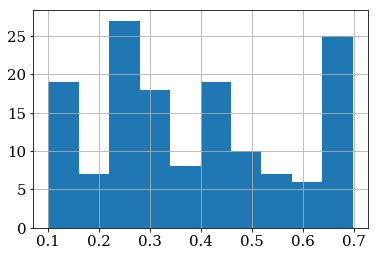

In [764]:

#National vulnerabilityb
v_unshaved =  vp_unshaved*df.share1 + vr_unshaved*(1-df.share1)
v_unshaved.name="v"
v_unshaved.index.name = "country"
v_unshaved.hist()

#Exposure guessed from dK and v
fa_guessed_gar = (frac_value_destroyed_gar/ broadcast_simple(v_unshaved,frac_value_destroyed_gar.index)).dropna()
fa_guessed_gar.name  = "fa"
# .dropna()


# fa_guessed_gar.to_csv("inputs/fa_guessed_from_GAR_and_PAGER.csv")

print(fa_guessed_gar.dropna().unstack("country").shape)


#Shaves exposure above 90% and increases vulnerability
fa_threshold =  0.9

excess=  fa_guessed_gar[fa_guessed_gar>fa_threshold].max(level="country")

vp = vp_unshaved.copy()
vr = vr_unshaved.copy()
v = v_unshaved.copy()

for c in excess.index:
    r = (excess/fa_threshold)[c]
    print(c,r, fa_guessed_gar[fa_guessed_gar>fa_threshold].ix[c])
    fa_guessed_gar.update(fa_guessed_gar.ix[[c]]/r)  # i don't care.
    vp.ix[c] *= r
    vr.ix[c] *= r
    v.ix[c] *=r
    
vp = vp.clip(upper=.99)
vr = vr.clip(upper=.99)

fa_guessed_gar.to_csv("inputs/fa_guessed_from_GAR_and_PAGER_shaved.csv")
# vp.to_csv("inputs/")

pd.DataFrame([vp,vr,v], index=["vp","vr","v"]).T.to_csv("inputs/v_pr_fromPAGER_shaved_GAR.csv")

print("check")
vp[excess.index], vr.ix[excess.index]

(country
 Senegal    0.7
 Nepal      0.7
 dtype: float64, country
 Senegal    0.685000
 Nepal      0.398766
 dtype: float64)

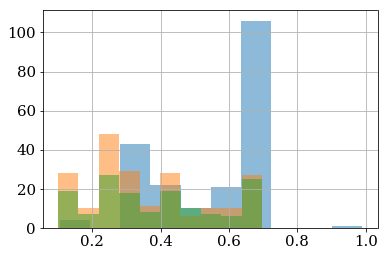

In [765]:

vp.hist(alpha=1/2)
vr.hist(alpha=1/2)
v_unshaved.hist(alpha=1/2)


vp[["Senegal","Nepal"]], vr[["Senegal","Nepal"]]

In [766]:
df.drop(['peb1', 'peb2'],axis=1).dropna().shape 

(123, 22)

In [767]:
df.columns

Index(['gdp_pc_pp', 'pop', 'share1', 'urbanization_rate', 'axfin_p', 'axfin_r',
       'social_p', 'social_r', 'pov_head', 'shew', 'prepare_scaleup',
       'finance_pre', 'rating', 'borrow_abi', 'avg_prod_k', 'T_rebuild_K',
       'pi', 'income_elast', 'rho', 'shareable', 'max_increased_spending',
       'fa_glofris', 'peb1', 'peb2'],
      dtype='object')

In [768]:
#SIDS with macro and Glofris data and pe data and GAR data
df.loc[list(list_of_sids),:].drop(['peb1', 'peb2'],axis=1).dropna().reset_index().country.unique()

array(['Dominican Republic', 'Jamaica'], dtype=object)

In [769]:
#SIDS with macro and pe data and GAR data
df.loc[list(list_of_sids),:].drop(['peb1', 'peb2','fa_glofris'],axis=1).dropna().reset_index().country.unique()

array(['Comoros', 'Dominican Republic', 'Jamaica', 'Mauritius'], dtype=object)

In [770]:
#SIDS with GAR fa data
fa_guessed_gar.loc[list(list_of_sids)].dropna().reset_index().country.unique()

array(['Comoros', 'Dominican Republic', 'Fiji', 'Guinea-Bissau', 'Haiti',
       'Jamaica', 'Kiribati', 'Maldives', 'Mauritius',
       'Micronesia, Fed. Sts.', 'Papua New Guinea', 'Seychelles',
       'Solomon Islands', 'Timor-Leste', 'Tonga', 'Tuvalu', 'Vanuatu'], dtype=object)

In [771]:
#SIDS with PAGER and GAR v data
vr.loc[list(list_of_sids)].dropna().reset_index().country.unique()

array(['American Samoa', 'Antigua and Barbuda', 'Aruba', 'Bahamas, The',
       'Bahrain', 'Barbados', 'Belize', 'Bermuda', 'Cayman Islands',
       'Comoros', 'Cuba', 'Dominica', 'Dominican Republic', 'Fiji',
       'French Polynesia', 'Grenada', 'Guinea-Bissau', 'Guyana', 'Haiti',
       'Jamaica', 'Kiribati', 'Maldives', 'Marshall Islands', 'Mauritius',
       'Micronesia, Fed. Sts.', 'New Caledonia', 'Palau',
       'Papua New Guinea', 'Puerto Rico', 'St. Kitts and Nevis',
       'St. Lucia', 'St. Vincent and the Grenadines', 'Seychelles',
       'Singapore', 'Solomon Islands', 'Suriname', 'Timor-Leste', 'Tonga',
       'Trinidad and Tobago', 'Turks and Caicos Islands', 'Tuvalu',
       'Virgin Islands (U.S.)', 'Vanuatu'], dtype=object)

## incorporates exposure bias, but only for (riverine) flood and surge


In [772]:
#exposure per hazard and income
fa_hazard_cat = broadcast_simple(fa_guessed_gar,index=income_cats)
fa_hazard_cat;

#uses pe in all hazard
fa_with_pe = concat_categories(fa_guessed_gar*(1+pe),fa_guessed_gar*(1-df.pov_head*(1+pe))/(1-df.pov_head), index=income_cats)
fa_with_pe

#selects just flood and surge
fa_with_pe = pd.DataFrame(fa_with_pe).query("hazard in ['flood','surge']").squeeze()

#updates fa_guessed_gar where necessary
fa_hazard_cat.update(fa_with_pe)

fa_hazard_cat.ix["Philippines"].unstack("hazard")

hazard             earthquake     flood     surge   tsunami      wind
rp     income_cat                                                    
20.0   nonpoor       0.019169  0.013200  0.019324  0.000363  0.104312
       poor          0.019169  0.013017  0.019055  0.000363  0.104312
50.0   nonpoor       0.038192  0.028777  0.024242  0.000869  0.142251
       poor          0.038192  0.028377  0.023905  0.000869  0.142251
100.0  nonpoor       0.059465  0.048798  0.029756  0.002357  0.169690
       poor          0.059465  0.048120  0.029342  0.002357  0.169690
250.0  nonpoor       0.100200  0.213656  0.031157  0.011524  0.208010
       poor          0.100200  0.210684  0.030724  0.011524  0.208010
500.0  nonpoor       0.147767  0.238280  0.033493  0.023708  0.226411
       poor          0.147767  0.234964  0.033027  0.023708  0.226411
1000.0 nonpoor       0.215005  0.280180  0.038164  0.043801  0.251127
       poor          0.215005  0.276282  0.037633  0.043801  0.251127
1500.0 nonpoor       0.261187  0.296833  0.039183  0.069123  0.275843
       poor          0.261187  0.292703  0.038638  0.069123  0.275843

## gathers hazard ratios

In [773]:
#fa from GAR
hazard_ratios = pd.DataFrame(fa_hazard_cat)


#shew at 0 for earthquake
hazard_ratios["shew"]=broadcast_simple(df.shew, index=hazard_ratios.index)
# hazard_ratios
hazard_ratios["shew"]=hazard_ratios.shew.unstack("hazard").assign(earthquake=0).stack("hazard").reset_index().set_index(event_level+[ "income_cat"])

if not no_protection:
    #protection at 0 for earthquake and wind
    hazard_ratios["protection"]=1
    hazard_ratios["protection"]=hazard_ratios.protection.unstack("hazard").assign(earthquake=1, wind=1).stack("hazard").reset_index().set_index(event_level)

hazard_ratios.sample(5)

,,,,fa,shew
country,hazard,rp,income_cat,,
Togo,earthquake,1500.0,nonpoor,0.000000,0.0
Senegal,flood,500.0,nonpoor,0.017612,0.6
Mozambique,tsunami,1500.0,nonpoor,0.000000,0.8
Hungary,flood,100.0,nonpoor,0.112693,1.0
Burkina Faso,earthquake,250.0,poor,0.000000,0.0


In [774]:
hazard_ratios.ix["Finland"].fa.max()

0.0

In [775]:
hazard_ratios= hazard_ratios.drop("Finland")

In [776]:
#SIDS with macro data and hazard_ratios data
set(macro_data_sids).intersection(list(hazard_ratios.loc[list(list_of_sids),:].dropna().reset_index().country.unique()))

{'Comoros', 'Dominican Republic', 'Jamaica', 'Mauritius'}

### countries with all data

In [777]:
hazard_ratios.unstack(["hazard","rp",])["fa"].replace(0,np.nan).dropna().stack(["hazard","rp",]).reset_index("country").country.unique()

array(['Japan', 'Papua New Guinea', 'Philippines'], dtype=object)

In [778]:
counter = hazard_ratios.fa.unstack(["rp","country"])[20].replace(0,np.nan).isnull()
# counter
(counter.shape[0]-counter.sum(axis=0)).sort_values(ascending=False).head(n=30)/2

country
Papua New Guinea         5.0
Philippines              5.0
Japan                    5.0
Jamaica                  4.0
France                   4.0
Dominican Republic       4.0
Nicaragua                4.0
Haiti                    4.0
Honduras                 4.0
Mozambique               4.0
Solomon Islands          4.0
China                    4.0
India                    4.0
Mexico                   4.0
Indonesia                4.0
Bangladesh               4.0
Venezuela, RB            4.0
Madagascar               4.0
United States            4.0
United Kingdom           4.0
Tonga                    3.0
Australia                3.0
Fiji                     3.0
Vietnam                  3.0
Pakistan                 3.0
Vanuatu                  3.0
Comoros                  3.0
Chile                    3.0
Canada                   3.0
Micronesia, Fed. Sts.    3.0
dtype: float64

In [779]:
(counter.shape[1]-counter.sum(axis=1)).sort_values(ascending=False)

hazard      income_cat
flood       nonpoor       130
            poor          129
earthquake  poor          110
            nonpoor       110
wind        poor           30
            nonpoor        30
surge       poor           29
            nonpoor        29
tsunami     poor            7
            nonpoor         7
dtype: int64

# Protection

In [780]:


#df.protection.head()
if protection_from_flopros:
#protection from FLOPROS
    minrp = 1/2 #assumes nobody is flooded more than twice a year
    df["protection"]= pd.read_csv("inputs/protection_national_from_flopros.csv", index_col="country", squeeze=True 
                                 ).clip(lower=minrp)
else:
    #assumed a function of the income group
    protection_assumptions = pd.read_csv("inputs/protection_level_assumptions.csv", index_col="Income group", squeeze=True)
    df["protection"]=pd.read_csv("inputs/income_groups.csv",header =4,index_col=2)["Income group"].dropna().replace(protection_assumptions)

if less_ratios:
    df.protection = 2
    
if no_protection:
    p=hazard_ratios.reset_index("rp").rp.min()
    df.protection=p
    print("PROTECTION IS ",p)
    
df.protection.head()


PROTECTION IS  20.0


country
Afghanistan       20.0
Albania           20.0
Algeria           20.0
American Samoa    20.0
Andorra           20.0
Name: protection, dtype: float64

# Data by income categories

## number, income, diversification, access to finance

In [781]:
cat_info =pd.DataFrame()

#number
#ph = ph=df[\"pov_head\"]
cat_info["n"]  = concat_categories(ph,(1-ph),index= income_cats)

#consumption levels
cp=   df["share1"] /ph    *df["gdp_pc_pp"]
cr=(1-df["share1"])/(1-ph)*df["gdp_pc_pp"]
cat_info["c"]       = concat_categories(cp,cr,index= income_cats)

#diversification
cat_info["social"]  = concat_categories(df.social_p,df.social_r,index= income_cats)


cat_info["axfin"] = concat_categories(df.axfin_p,df.axfin_r,index= income_cats)


    
#access to finance
# cat_info["axfin"]   = concat_categories(df.axfin_p,df.axfin_r)

cat_info = cat_info.dropna()
cat_info.head()

n             c    social     axfin
country   income_cat                                       
Albania   nonpoor     0.8  12550.402351  0.168006  0.096454
          poor        0.2   4874.210019  0.243888  0.044618
Angola    nonpoor     0.8   8201.147101  0.104156  0.222081
          poor        0.2   1883.566829  0.140762  0.040259
Argentina nonpoor     0.8  21526.024451  0.145651  0.060690

In [782]:
#SIDS with macro data
cat_info.loc[list(list_of_sids),:].dropna().reset_index().country.unique()

array(['Comoros', 'Dominican Republic', 'Haiti', 'Jamaica', 'Mauritius'], dtype=object)

## Taxes, redistribution, capital

In [783]:
#computes tau tax and gamma_sp from socail_poor and social_nonpoor
df["tau_tax"],cat_info["gamma_SP"] = social_to_tx_and_gsp(cat_info)

cat_info["k"] = (1-cat_info["social"])*cat_info["c"]/((1-df["tau_tax"])*df["avg_prod_k"])

cat_info.head()


n             c    social     axfin  gamma_SP  \
country   income_cat                                                    
Albania   nonpoor     0.8  12550.402351  0.168006  0.096454  1.095582   
          poor        0.2   4874.210019  0.243888  0.044618  0.617673   
Angola    nonpoor     0.8   8201.147101  0.104156  0.222081  1.159988   
          poor        0.2   1883.566829  0.140762  0.040259  0.360049   
Argentina nonpoor     0.8  21526.024451  0.145651  0.060690  1.169169   

                                 k  
country   income_cat                
Albania   nonpoor     68288.702566  
          poor        24102.441325  
Angola    nonpoor     19008.866794  
          poor         4187.392610  
Argentina nonpoor     80104.035446

In [784]:
#doubles checks the round trip from social to (tx and gammasp) and back to social
((unpack_social(df,cat_info)- cat_info.social)**2).sum()

8.03646931442491e-31

In [785]:
#SIDS with macro data
cat_info.loc[list(list_of_sids),:].dropna().reset_index().country.unique()

array(['Comoros', 'Dominican Republic', 'Jamaica', 'Mauritius'], dtype=object)

## Exposure 

In [786]:
#Exposure the the 100 yr river flood as "default" case
cat_info["fa"] =hazard_ratios.fa.mean(level=["country","income_cat"])
cat_info["fa"];
# cat_info[cat_info.fa.isnull()]
# cat_info["fa"] = concat_categories((1+pe),(1-df.pov_head*(1+pe))/(1-df.pov_head), index=income_cats)
cat_info.head()
# cat_info[["fa","n"]].prod(axis=1).sum(level="country")/df.fa

n             c    social     axfin  gamma_SP  \
country   income_cat                                                    
Albania   nonpoor     0.8  12550.402351  0.168006  0.096454  1.095582   
          poor        0.2   4874.210019  0.243888  0.044618  0.617673   
Angola    nonpoor     0.8   8201.147101  0.104156  0.222081  1.159988   
          poor        0.2   1883.566829  0.140762  0.040259  0.360049   
Argentina nonpoor     0.8  21526.024451  0.145651  0.060690  1.169169   

                                 k        fa  
country   income_cat                          
Albania   nonpoor     68288.702566  0.025179  
          poor        24102.441325  0.024174  
Angola    nonpoor     19008.866794  0.003203  
          poor         4187.392610  0.014163  
Argentina nonpoor     80104.035446  0.009717

In [787]:
cat_info.loc[list(list_of_sids),:].dropna().reset_index().country.unique()

array(['Comoros', 'Dominican Republic', 'Jamaica', 'Mauritius'], dtype=object)

## Vulnerability

In [788]:
cat_info["v"] = concat_categories(vp,vr, index=income_cats)
cat_info.head()

n             c    social     axfin  gamma_SP  \
country   income_cat                                                    
Albania   nonpoor     0.8  12550.402351  0.168006  0.096454  1.095582   
          poor        0.2   4874.210019  0.243888  0.044618  0.617673   
Angola    nonpoor     0.8   8201.147101  0.104156  0.222081  1.159988   
          poor        0.2   1883.566829  0.140762  0.040259  0.360049   
Argentina nonpoor     0.8  21526.024451  0.145651  0.060690  1.169169   

                                 k        fa         v  
country   income_cat                                    
Albania   nonpoor     68288.702566  0.025179  0.351500  
          poor        24102.441325  0.024174  0.700000  
Angola    nonpoor     19008.866794  0.003203  0.600000  
          poor         4187.392610  0.014163  0.700000  
Argentina nonpoor     80104.035446  0.009717  0.397254

# access to early warnings

In [789]:
 hazard_ratios.shew.drop("eathrquake", level="hazard").mean(level=["country","income_cat"]);

In [790]:
cat_info["shew"] = hazard_ratios.shew.drop("eathrquake", level="hazard").mean(level=["country","income_cat"])

In [791]:
cat_info.head()

n             c    social     axfin  gamma_SP  \
country   income_cat                                                    
Albania   nonpoor     0.8  12550.402351  0.168006  0.096454  1.095582   
          poor        0.2   4874.210019  0.243888  0.044618  0.617673   
Angola    nonpoor     0.8   8201.147101  0.104156  0.222081  1.159988   
          poor        0.2   1883.566829  0.140762  0.040259  0.360049   
Argentina nonpoor     0.8  21526.024451  0.145651  0.060690  1.169169   

                                 k        fa         v  shew  
country   income_cat                                          
Albania   nonpoor     68288.702566  0.025179  0.351500  0.00  
          poor        24102.441325  0.024174  0.700000  0.00  
Angola    nonpoor     19008.866794  0.003203  0.600000  0.00  
          poor         4187.392610  0.014163  0.700000  0.00  
Argentina nonpoor     80104.035446  0.009717  0.397254  0.64

In [792]:
cat_info.loc[list(list_of_sids),:].dropna().reset_index().country.unique()

array(['Comoros', 'Dominican Republic', 'Jamaica', 'Mauritius'], dtype=object)

## missing data per income category

In [793]:
report_missing_data(cat_info).reset_index("income_cat", drop=True).reset_index().drop_duplicates()

,country,nb_missing,missing_data
0,Haiti,1,k
2,Nicaragua,1,k
4,West Bank and Gaza,1,k
6,Finland,2,"fa, shew"
8,Kosovo,4,"k, fa, v, shew"


In [794]:
if drop_unused_data:
    cat_info= cat_info.drop(["social"],axis=1, errors="ignore").dropna()
cat_info.head()

n             c     axfin  gamma_SP             k  \
country   income_cat                                                        
Albania   nonpoor     0.8  12550.402351  0.096454  1.095582  68288.702566   
          poor        0.2   4874.210019  0.044618  0.617673  24102.441325   
Angola    nonpoor     0.8   8201.147101  0.222081  1.159988  19008.866794   
          poor        0.2   1883.566829  0.040259  0.360049   4187.392610   
Argentina nonpoor     0.8  21526.024451  0.060690  1.169169  80104.035446   

                            fa         v  shew  
country   income_cat                            
Albania   nonpoor     0.025179  0.351500  0.00  
          poor        0.024174  0.700000  0.00  
Angola    nonpoor     0.003203  0.600000  0.00  
          poor        0.014163  0.700000  0.00  
Argentina nonpoor     0.009717  0.397254  0.64

# Saves all data

In [798]:

if drop_unused_data:
#the data in these columns is now in cat_info

    df_in = df.drop(
        ["social_p", "social_r","share1","pov_head", "pe","vp","vr", "axfin_p",  "axfin_r","rating","finance_pre","peb1","peb2"],
        axis=1, errors="ignore")
    if not use_GLOFRIS_flood:
        df_in = df_in.drop(["fa_glofris"],axis=1, errors="ignore")

    df_in = df_in.dropna()
    print(df_in.columns)
else :
    df_in = df.dropna()


#also removes "intermediate" data
df_in = df_in.drop([ "shew","v"],
                  axis=1, errors="ignore").dropna()
    

Index(['gdp_pc_pp', 'pop', 'urbanization_rate', 'shew', 'prepare_scaleup',
       'borrow_abi', 'avg_prod_k', 'T_rebuild_K', 'pi', 'income_elast', 'rho',
       'shareable', 'max_increased_spending', 'protection', 'tau_tax'],
      dtype='object')


In [799]:

df_in.to_csv("intermediate/macro.csv")
df_in.shape

(126, 14)

In [800]:
df_in.loc[list(list_of_sids),:].dropna().reset_index().country.unique()

array(['Comoros', 'Dominican Republic', 'Jamaica', 'Mauritius'], dtype=object)

In [801]:
df_in.loc[list(list_of_sids),:].dropna()

,gdp_pc_pp,pop,urbanization_rate,prepare_scaleup,borrow_abi,avg_prod_k,T_rebuild_K,pi,income_elast,rho,shareable,max_increased_spending,protection,tau_tax
country,,,,,,,,,,,,,,
Comoros,1393.256081,788474.0,0.28296,0.266667,0.166667,0.197959,3.0,0.2,1.5,0.06,0.8,0.05,20.0,0.027326
Dominican Republic,13371.528798,10528391.0,0.78980,0.600000,0.508333,0.377150,3.0,0.2,1.5,0.06,0.8,0.05,20.0,0.123135
Jamaica,8333.484528,2793335.0,0.54788,0.600000,0.408333,0.381009,3.0,0.2,1.5,0.06,0.8,0.05,20.0,0.153719
Mauritius,18864.105666,1262605.0,0.39671,0.733333,0.741667,0.294813,3.0,0.2,1.5,0.06,0.8,0.05,20.0,0.333311


In [613]:
cat_info.to_csv("intermediate/cat_info.csv")
cat_info.head()

n             c     axfin  gamma_SP             k  \
country   income_cat                                                        
Albania   nonpoor     0.8  12550.402351  0.096454  1.095582  68288.702566   
          poor        0.2   4874.210019  0.044618  0.617673  24102.441325   
Angola    nonpoor     0.8   8201.147101  0.222081  1.159988  19008.866794   
          poor        0.2   1883.566829  0.040259  0.360049   4187.392610   
Argentina nonpoor     0.8  21526.024451  0.060690  1.169169  80104.035446   

                            fa         v  shew  
country   income_cat                            
Albania   nonpoor     0.025179  0.351500  0.00  
          poor        0.024174  0.700000  0.00  
Angola    nonpoor     0.003203  0.600000  0.00  
          poor        0.014163  0.700000  0.00  
Argentina nonpoor     0.009717  0.397254  0.64

In [614]:
cat_info.loc[list(list_of_sids),:].dropna()

n             c     axfin  gamma_SP  \
country            income_cat                                          
Comoros            nonpoor     0.8   1671.733140  0.147553  1.182853   
                   poor        0.2    279.347844  0.035311  0.268589   
Dominican Republic nonpoor     0.8  15890.390536  0.339857  1.141545   
                   poor        0.2   3296.081849  0.160156  0.433821   
Jamaica            nonpoor     0.8   9866.845681  0.352092  1.135569   
                   poor        0.2   2200.039915  0.214720  0.457723   
Mauritius          nonpoor     0.8  21830.486282  0.436775  1.138863   
                   poor        0.2   6998.583202  0.231974  0.444549   

                                          k        fa         v  shew  
country            income_cat                                          
Comoros            nonpoor      8448.222812  0.014305  0.442447  0.45  
                   poor         1397.679020  0.014598  0.700000  0.45  
Dominican Republic nonpoor     42365.921265  0.116973  0.300000  0.64  
                   poor         7806.825997  0.115993  0.348997  0.64  
Jamaica            nonpoor     26089.023129  0.139503  0.391376  0.64  
                   poor         5004.605609  0.141286  0.700000  0.64  
Mauritius          nonpoor     74636.850535  0.035892  0.300000  0.60  
                   poor        21386.233668  0.036809  0.300000  0.60

In [615]:
hazard_ratios.loc[list(list_of_sids),:].dropna().reset_index().country.unique()

array(['Comoros', 'Dominican Republic', 'Fiji', 'Guinea-Bissau', 'Haiti',
       'Jamaica', 'Kiribati', 'Maldives', 'Mauritius',
       'Micronesia, Fed. Sts.', 'Papua New Guinea', 'Seychelles',
       'Solomon Islands', 'Timor-Leste', 'Tonga', 'Tuvalu', 'Vanuatu'], dtype=object)

In [616]:

hazard_ratios.to_csv("intermediate/hazard_ratios.csv")
hazard_ratios.head()

fa  shew
country hazard     rp    income_cat                
Albania earthquake 20.0  nonpoor     0.007294   0.0
                         poor        0.007294   0.0
                   50.0  nonpoor     0.015454   0.0
                         poor        0.015454   0.0
                   100.0 nonpoor     0.026673   0.0

# Set up the sensitivity anlysis

In [617]:
####Sensitivity analysis following instructions in alt_params.csv

country_sens_list=["Malawi","Sweden"]

#reads paramters to be varied
alt_params=pd.read_csv("inputs/alt_params.csv")

df_sensit = pd.DataFrame(columns=df.columns)

for c in country_sens_list:

    for p in alt_params.index.tolist():
        param = alt_params.ix[p,"param"]
        
        new_value = alt_params.ix[p,"value"]
        if new_value[0] in "/*":
            new_value = str(df.ix[c,param])+new_value         
        new_value = eval(new_value)
        
        if alt_params.ix[p,"unit"]=="%":
            suffix = " $({name}={nv:2.0f}\%)$".format(name=alt_params.ix[p,"formated_name"],nv=100*new_value) 
        else    :
            suffix = " $({name}={nv:2.0f}{unit})$".format(name=alt_params.ix[p,"formated_name"],nv=new_value, unit =alt_params.ix[p,"unit"] )
        d = c+suffix
        df_sensit.ix[d] = df.ix[c]
        df_sensit.ix[d,param] =new_value
        df_sensit.ix[d,"original_country"]=c
        
        #sets reference values 
#         df_sensit =def_ref_values(df_sensit)
        
    
    #special treatment for fa
    #df_sensit.ix[d,param] =new_value
    
for c in df.dropna().index: #senstitivity for all countries  (actually very long)    
    for param in ["income_elast"]:
        for new_value in [1, 2]:
            d = c+" $(\eta="+str(new_value)+")$"
            df_sensit.ix[d] = df.ix[c]
            df_sensit.ix[d,param] =new_value
            df_sensit.ix[d,"original_country"]=c

df_sensit=df_sensit.sort_index().sort_index(axis=1)            
            
df_sensit.index.name="country"; #after adding indices pandas forgets their 
df_sensit.drop("iso3", axis=1).to_csv("results/df_sensit_input.csv")

fa_ratios_sensib= df_sensit[["original_country"]].merge(fa_ratios,right_index=True,left_on="original_country").drop(["original_country"], axis=1)
fa_ratios_sensib.to_csv("results/fa_ratios_sensib.csv")

compute_resiliences(df_sensit, fa_ratios=fa_ratios_sensib).to_csv("results/df_sensit_results.csv")

KeyError: 'fa'

# Junkyard

In [ ]:
cat_info.fa.unstack().assign(bias = lambda s:s.poor/s.nonpoor).sort_values(by="bias", ascending=False)

# Simple OLSs

## Resilience

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [ ]:
experiments_cols=[
'axfin_p', 'axfin_r', 'axhealth', 'bashs', 'finance_pre', 'ophe', 'avg_prod_k', 
       'pe',  'plgp',  'prepare_scaleup',  'pv', 'rating', 'share1', 'social_p', 'social_r', 'unemp']
varin = "resilience"

formula = varin+" ~ " + "+".join(experiments_cols)
olsmodel=ols(formula,data=df_with_results).fit()
olsmodel.summary()

pd.DataFrame( [olsmodel.params, olsmodel.pvalues], index=["coeff", "pval"]).T
olsmodel.summary()
# table=anova_lm(olsmodel)
# table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
# b=table.sort_values(by="sum_sq_pc", ascending=False)["sum_sq_pc"].reset_index()
# b["desc"]=b["index"].replace(pd.read_csv("inputs_info.csv",usecols=["key","descriptor"],index_col="key",squeeze=True))
# b=b.set_index("desc").drop("index",axis=1)
# b.to_csv("anova.csv")
# b.head(12)

In [ ]:
import matplotlib.pyplot as plt


def plot_barh(a,color="#9ecae1", xlabel=""):
    #params 
    n=len(a)
    height=.38
    pos=np.arange(n)

    #new fig
    fig, ax = plt.subplots(figsize=(5,n/1.75))
    rects=plt.barh(pos-height/2,(100*a), height=height, color=color, clip_on=False);

    #Department labels
    ax.set_yticks(pos)
    ax.set_yticklabels(a.index)

    #X axis
    ax.xaxis.set_ticklabels([])
    ax.set_xlabel(xlabel);

    #X labels
    autolabel(ax,rects,"gray",2)

    #no spines
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color("none")

    #no ticks
    for tic in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    plt.tight_layout()
    return ax    

In [ ]:
def spine_and_ticks(ax):
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color("none")

    #removes ticks 
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
from autolabel import *    
   
    
    
def plot_barh(a,color="#9ecae1", xlabel=""):
    #params 
    n=len(a)
    height=.38
    pos=np.arange(n)

    #new fig
    fig, ax = plt.subplots(figsize=(6,n/1.75))
    rects=plt.barh(pos-height/2,(100*a), height=height, color=color, clip_on=False);

    #Department labels
    ax.set_yticks(pos)
    ax.set_yticklabels(a.index)

    #X axis
    ax.xaxis.set_ticklabels([])
#     ax.set_title(xlabel);

    #X labels
    autolabel(ax,rects,"gray",2)
#     ax.set_xlabel("Average error (%)")

    #no spines
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color("none")

    #no ticks
    for tic in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    plt.tight_layout()
    return ax    
    
    


In [ ]:
plot_barh(info.sort_values("risk", ascending=True).risk.tail(10), color="#756bb1", xlabel="Average error (%)")
plt.savefig("img/risk_info.png", bbox_inches="tight")

In [ ]:
plot_barh(info.sort_values("resilience", ascending=True).resilience.tail(10), color="#de2d26")
plt.savefig("img/ser_info.png", bbox_inches="tight")

In [ ]:
plot_barh(info.sort_values("risk_to_assets", ascending=True).risk_to_assets.tail(10), color="#3182bd")
plt.savefig("img/risk_to_assets_info.png", bbox_inches="tight")

In [ ]:
ax=df.plot.scatter(y="fa_glofris",       x="fa_gar_guessed", alpha=0.7, s=50,clip_on=False, color="#fc8d62", figsize=(6,6))
ax=df.plot.scatter(y="asset_fa", x="fa_gar_guessed", alpha=0.7, s=50,clip_on=False, ax=ax, color="#8da0cb")
plt.legend(["People", "Assets"])
plt.xlabel("fa guessed from GAR and PAGER")
plt.ylabel("GLOFRIS")
plt.xlim(0,.5)
plt.ylim(0,.5)

plt.savefig("fig/GAR_vs_GLOFRIS")


ax=df.plot.scatter(loglog=True,y="fa_glofris",       x="fa_gar_guessed", alpha=0.7, s=50,clip_on=False, color="#fc8d62", figsize=(6,6))
ax=df.plot.scatter(loglog=True,y="asset_fa", x="fa_gar_guessed", alpha=0.7, s=50,clip_on=False, ax=ax, color="#8da0cb")
plt.legend(["People", "Assets"], loc="upper left")
plt.xlabel("fa guessed from GAR and PAGER")
plt.ylabel("GLOFRIS")
plt.xlim(0,.5)
plt.ylim(0,.5)

plt.savefig("fig/GAR_vs_GLOFRIS_log_log")


ax=df.plot.scatter(y="fa_glofris", x="fadK_gar_flood", alpha=0.7, s=50,clip_on=False, color="#fc8d62", figsize=(6,6))
ax=df.plot.scatter(y="asset_fa", x="fadK_gar_flood", alpha=0.7, s=50,clip_on=False, ax=ax, color="#8da0cb")
plt.legend(["People", "Assets"])
plt.xlabel("Assets destroyed in GAR")
plt.ylabel("GLOFRIS")
plt.xlim(0)
plt.ylim(0)

